# PM_980 DATASET FOR SIGNAL CLASSIFICATION

In [2]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import re
import copy

from scipy.fft import rfft
from scipy.stats import skew, kurtosis

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, precision_recall_fscore_support
)
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif

from tensorflow.keras.utils import to_categorical

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.utils import class_weight

In [3]:
import warnings
warnings.filterwarnings('ignore')  

In [4]:
import os
import pandas as pd
import numpy as np
import re

data_dir = "PM980"  
all_data = []
labels = []

for filename in os.listdir(data_dir):
    if filename.endswith('.csv'):
        file_path = os.path.join(data_dir, filename)
        df = pd.read_csv(file_path)

        match = re.match(r"(\d+\.\d+)_(\d+\.\d+)_([a-zA-Z]+)_.*\.csv", filename)
        if match:
            speed_start, speed_end, label = match.groups()
            df['label'] = label
            df['speed_start'] = float(speed_start)
            df['speed_end'] = float(speed_end)
            
            all_data.append(df)

In [5]:
full_df = pd.concat(all_data, ignore_index=True)

In [6]:
full_df.isnull().sum()

Speed             0
Voice             0
Acceleration X    0
Acceleration Y    0
Acceleration Z    0
Gyro X            0
Gyro Y            0
Gyro Z            0
Temperature       0
Speed_Range       0
label             0
speed_start       0
speed_end         0
dtype: int64

In [7]:
full_df.head()

,Speed,Voice,Acceleration X,Acceleration Y,Acceleration Z,Gyro X,Gyro Y,Gyro Z,Temperature,Speed_Range,label,speed_start,speed_end
0,100.0,2927.0,-0.26,-0.98,7.86,-0.49,4.23,0.96,27.17,100.0-110.0,healthynotchlong,100.0,110.0
1,100.0,2927.0,0.20,1.92,9.58,5.46,12.23,0.82,27.16,100.0-110.0,healthynotchlong,100.0,110.0
2,100.0,0.0,4.45,1.50,10.95,4.57,1.38,-0.73,27.17,100.0-110.0,healthynotchlong,100.0,110.0
3,100.0,848.0,-6.03,0.05,9.65,2.12,5.79,-0.40,27.19,100.0-110.0,healthynotchlong,100.0,110.0
4,100.0,1894.0,-4.29,-2.71,7.02,-4.37,-1.14,0.53,27.16,100.0-110.0,healthynotchlong,100.0,110.0


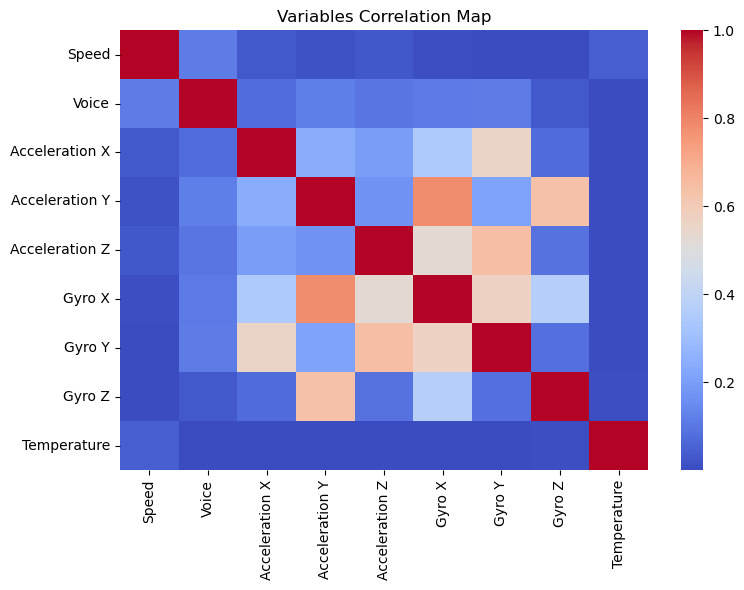

In [8]:
plt.figure(figsize=(8, 6))
sns.heatmap(full_df.drop(columns=['label', 'Speed_Range', 'speed_start', 'speed_end']).corr().abs(), annot=False, cmap='coolwarm')
plt.title("Variables Correlation Map")
plt.tight_layout()
plt.show()

## Feature Engineering

### Frequency Features

In [11]:
from scipy.fft import fft
from sklearn.preprocessing import LabelEncoder

def extract_features(df):
    features = {}
    sensors = ['Voice', 'Acceleration X', 'Acceleration Y', 'Acceleration Z',
               'Gyro X', 'Gyro Y', 'Gyro Z', 'Temperature']
    
    for sensor in sensors:
        signal = df[sensor].values
        features[f'{sensor}_mean'] = np.mean(signal)
        features[f'{sensor}_std'] = np.std(signal)
        features[f'{sensor}_min'] = np.min(signal)
        features[f'{sensor}_max'] = np.max(signal)
        
        fft_vals = np.abs(fft(signal))[:5]
        for i, val in enumerate(fft_vals):
            features[f'{sensor}_fft{i}'] = val
    
    return pd.Series(features)


In [12]:
features_list = []
labels = []

for name, group in full_df.groupby(['speed_start', 'speed_end', 'label']):
    features = extract_features(group)
    features['label'] = name[2]
    features['speed_start'] = name[0]
    features['speed_end'] = name[1]
    features['Speed_Range'] = f"{name[0]}_{name[1]}"  
    features_list.append(features)

feature_df = pd.DataFrame(features_list)

## Cross-Correlation & Important Features

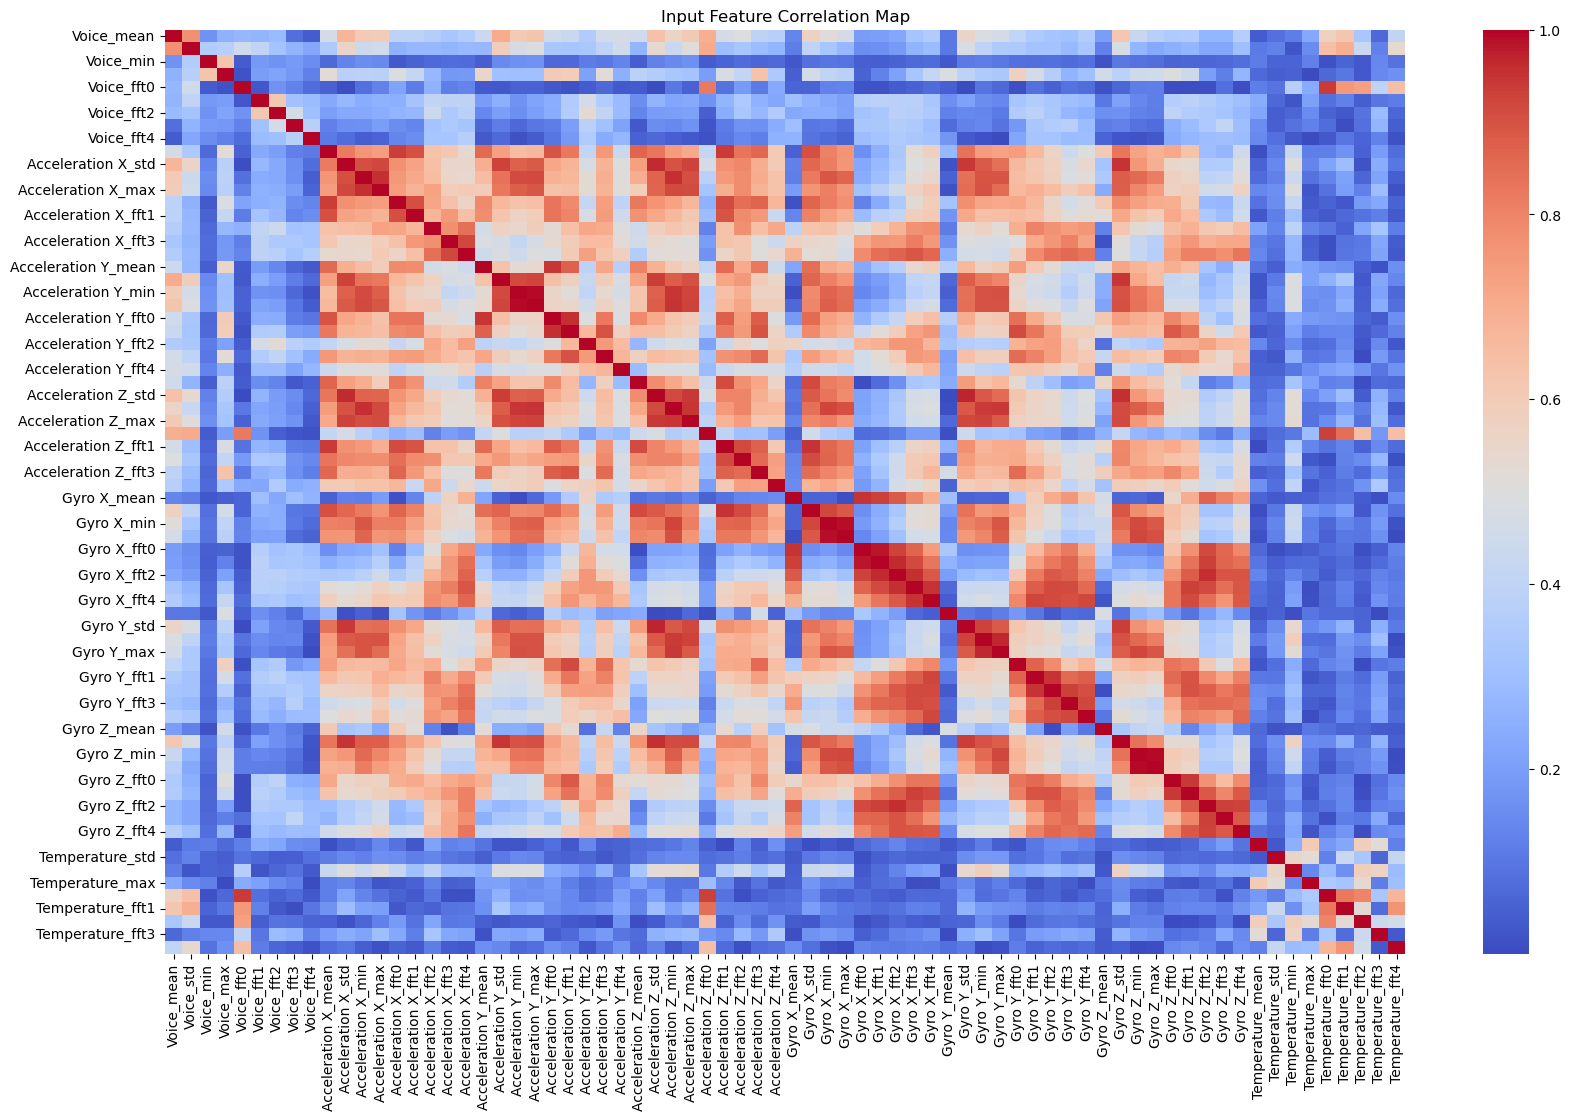

In [14]:
plt.figure(figsize=(20, 12))
sns.heatmap(
    feature_df.drop(columns=['label', 'speed_start', 'speed_end', "Speed_Range"]).corr().abs(),
    cmap='coolwarm',
    annot=False
)
plt.title('Input Feature Correlation Map')
plt.show()

In [15]:
feature_df.columns

Index(['Voice_mean', 'Voice_std', 'Voice_min', 'Voice_max', 'Voice_fft0',
       'Voice_fft1', 'Voice_fft2', 'Voice_fft3', 'Voice_fft4',
       'Acceleration X_mean', 'Acceleration X_std', 'Acceleration X_min',
       'Acceleration X_max', 'Acceleration X_fft0', 'Acceleration X_fft1',
       'Acceleration X_fft2', 'Acceleration X_fft3', 'Acceleration X_fft4',
       'Acceleration Y_mean', 'Acceleration Y_std', 'Acceleration Y_min',
       'Acceleration Y_max', 'Acceleration Y_fft0', 'Acceleration Y_fft1',
       'Acceleration Y_fft2', 'Acceleration Y_fft3', 'Acceleration Y_fft4',
       'Acceleration Z_mean', 'Acceleration Z_std', 'Acceleration Z_min',
       'Acceleration Z_max', 'Acceleration Z_fft0', 'Acceleration Z_fft1',
       'Acceleration Z_fft2', 'Acceleration Z_fft3', 'Acceleration Z_fft4',
       'Gyro X_mean', 'Gyro X_std', 'Gyro X_min', 'Gyro X_max', 'Gyro X_fft0',
       'Gyro X_fft1', 'Gyro X_fft2', 'Gyro X_fft3', 'Gyro X_fft4',
       'Gyro Y_mean', 'Gyro Y_std', 'Gyro 

## Explaining Inputs and Outputs

In [17]:
feature_df.to_csv("features_980.csv", index=False)

In [18]:
df = pd.read_csv("features_980.csv")

X = df.drop(columns=['label', 'speed_start', 'speed_end'])
y = df['label']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

le_speed = LabelEncoder()
X['Speed_Range'] = le_speed.fit_transform(X['Speed_Range'])


X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=13, stratify=y_encoded
)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Class Distribution (Train): {pd.Series(y_train).value_counts().to_dict()}")
print(f"Class Distribution (Test): {pd.Series(y_test).value_counts().to_dict()}")

Train shape: (128, 73), Test shape: (32, 73)
Class Distribution (Train): {7: 8, 0: 8, 14: 8, 15: 8, 9: 8, 1: 8, 3: 8, 8: 8, 11: 8, 5: 8, 10: 8, 12: 8, 6: 8, 13: 8, 4: 8, 2: 8}
Class Distribution (Test): {9: 2, 1: 2, 11: 2, 14: 2, 13: 2, 6: 2, 8: 2, 10: 2, 0: 2, 5: 2, 2: 2, 7: 2, 3: 2, 12: 2, 4: 2, 15: 2}


## Machine Learning, Evaluation & Model Selection

In [20]:
def stratified_cv_evaluate(model, X, y, label_encoder=None, cv=10):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=13)

    fold_results = []
    confusion_matrices = []
    y_true_all = []
    y_pred_all = []

    best_accuracy = -np.inf
    best_model = None

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        start_train = time.time()
        model.fit(X_train, y_train)
        train_time = time.time() - start_train

        start_test = time.time()
        y_pred = model.predict(X_test)
        test_time = time.time() - start_test

        acc = accuracy_score(y_test, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_test, y_pred, labels=np.unique(y), average='macro', zero_division=0)

        fold_results.append({
            'fold': fold,
            'accuracy': acc,
            'f1': f1,
            'precision': precision,
            'recall': recall,
            'train_time': train_time,
            'test_time': test_time
        })

        cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
        confusion_matrices.append(cm)

        y_true_all.extend(y_test)
        y_pred_all.extend(y_pred)

        if acc > best_accuracy:
            best_accuracy = acc
            best_model = copy.deepcopy(model)

        print(f"Fold {fold} — Accuracy: {acc:.4f}, Train time: {train_time:.4f}s, Test time: {test_time:.4f}s")

    results_df = pd.DataFrame(fold_results)

    avg_acc = results_df['accuracy'].mean()
    avg_train_time = results_df['train_time'].mean()
    avg_test_time = results_df['test_time'].mean()

    print("\n--- Average Performance ---")
    print(f"Accuracy: {avg_acc:.4f}")
    print(f"Avg. Training Time: {avg_train_time:.4f}s")
    print(f"Avg. Testing Time: {avg_test_time:.4f}s")

    if label_encoder is not None:
        class_names = label_encoder.classes_
    else:
        class_names = np.unique(y)

    best_fold_idx = results_df['accuracy'].idxmax()
    best_cm = confusion_matrices[best_fold_idx]

    return {
        'results_df': results_df,
        'average_accuracy': avg_acc,
        'average_train_time': avg_train_time,
        'average_test_time': avg_test_time,
        'best_confusion_matrix': best_cm,
        'best_fold_index': best_fold_idx,
        'all_true_labels': y_true_all,
        'all_pred_labels': y_pred_all,
        'best_model': best_model,
        'class_names': class_names
    }

In [21]:
from lightgbm import LGBMClassifier

model = LGBMClassifier(n_estimators=100, random_state=13, verbose=-1)

results = stratified_cv_evaluate(model, X, y_encoded, label_encoder=le, cv=10)
print(results['results_df'])

Fold 1 — Accuracy: 0.9375, Train time: 4.8632s, Test time: 0.0078s
Fold 2 — Accuracy: 0.8125, Train time: 3.9471s, Test time: 0.0054s
Fold 3 — Accuracy: 0.9375, Train time: 3.9920s, Test time: 0.0066s
Fold 4 — Accuracy: 0.7500, Train time: 4.0353s, Test time: 0.0066s
Fold 5 — Accuracy: 0.8750, Train time: 3.9599s, Test time: 0.0064s
Fold 6 — Accuracy: 0.8750, Train time: 3.3779s, Test time: 0.0065s
Fold 7 — Accuracy: 0.8125, Train time: 3.0275s, Test time: 0.0076s
Fold 8 — Accuracy: 0.7500, Train time: 3.2863s, Test time: 0.0066s
Fold 9 — Accuracy: 0.7500, Train time: 3.3965s, Test time: 0.0087s
Fold 10 — Accuracy: 0.6875, Train time: 3.9308s, Test time: 0.0069s

--- Average Performance ---
Accuracy: 0.8187
Avg. Training Time: 3.7817s
Avg. Testing Time: 0.0069s
   fold  accuracy        f1  precision  recall  train_time  test_time
0     1    0.9375  0.916667   0.906250  0.9375    4.863206   0.007793
1     2    0.8125  0.770833   0.750000  0.8125    3.947141   0.005395
2     3    0.9375 

## Visualize All Tried Results

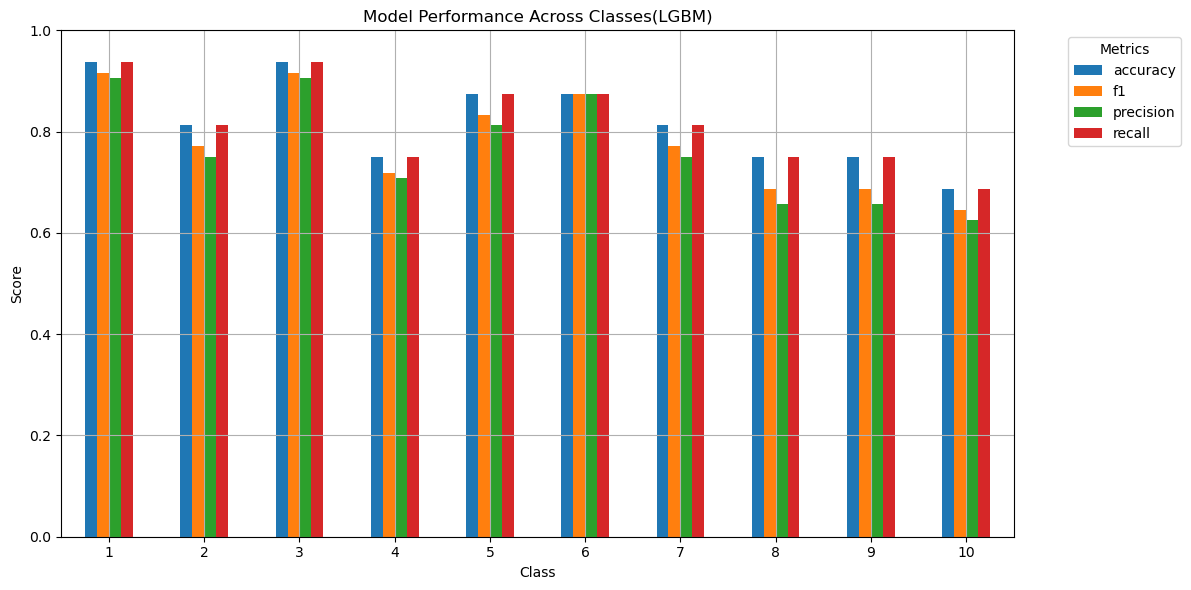

In [23]:
results_df = results['results_df']

results_df.plot(
    x='fold',
    y=['accuracy', 'f1', 'precision', 'recall'],
    kind='bar',
    figsize=(12, 6),
    ylim=(0, 1),  
    rot=0,
    grid=True
)

plt.title("Model Performance Across Classes(LGBM)")
plt.ylabel("Score")
plt.xlabel("Class")
plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')  
plt.tight_layout()
plt.show()

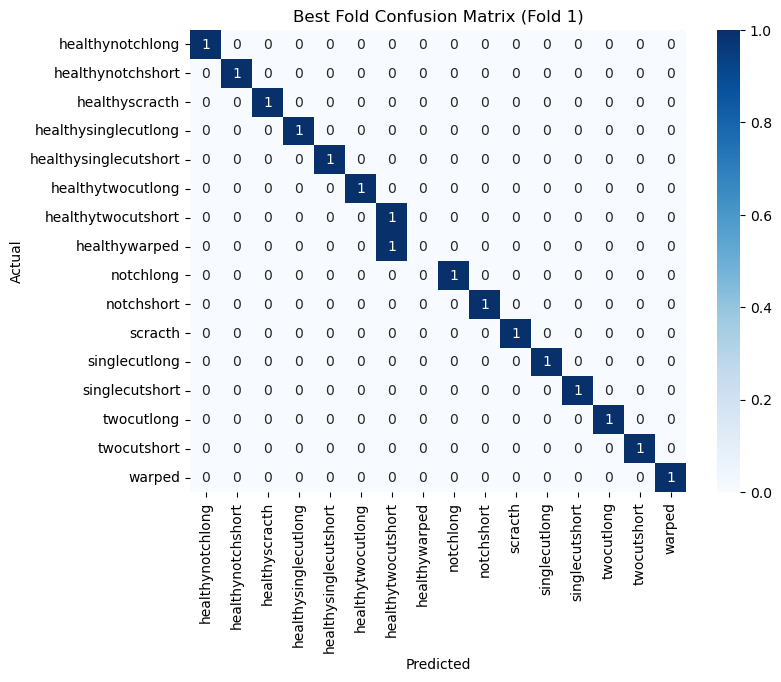

In [24]:
plt.figure(figsize=(8, 6))
sns.heatmap(results['best_confusion_matrix'], annot=True, fmt='d', cmap='Blues',
            xticklabels=results['class_names'], yticklabels=results['class_names'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Best Fold Confusion Matrix (Fold {results["best_fold_index"]+1})')
plt.show()

In [25]:
print("\n--- Classification Report for Best Model ---")
print(classification_report(results['all_true_labels'], 
                          results['all_pred_labels'],
                          target_names=results['class_names']))


--- Classification Report for Best Model ---
                       precision    recall  f1-score   support

     healthynotchlong       1.00      0.90      0.95        10
    healthynotchshort       0.75      0.90      0.82        10
       healthyscracth       0.69      0.90      0.78        10
 healthysinglecutlong       0.55      0.60      0.57        10
healthysinglecutshort       0.75      0.30      0.43        10
    healthytwocutlong       0.70      0.70      0.70        10
   healthytwocutshort       0.67      0.80      0.73        10
        healthywarped       0.45      0.50      0.48        10
            notchlong       1.00      1.00      1.00        10
           notchshort       1.00      1.00      1.00        10
              scracth       0.90      0.90      0.90        10
        singlecutlong       1.00      0.90      0.95        10
       singlecutshort       1.00      0.90      0.95        10
           twocutlong       0.91      1.00      0.95        10
        

## Best Model Performance & Parameters

In [27]:
best_model = results['best_model']

print("Model parameters:", best_model.get_params())

Model parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': 13, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1}


## Saving the Model

In [29]:
model_path = 'lgbm_model.pkl'
joblib.dump(best_model, model_path)

print(f"Model saved to file: '{model_path}'")

Model saved to file: 'lgbm_model.pkl'


## Model Deployment

In [31]:
loaded_model = joblib.load(model_path)

## Testing with Test Data & Showing Predictions

In [33]:
predictions = loaded_model.predict(X_test)
comparison = pd.DataFrame({"Actual": y_test, "Predicted": predictions})
comparison.head(10)

,Actual,Predicted
0,9,9
1,1,1
2,1,1
3,11,11
4,14,14
5,13,13
6,6,6
7,8,8
8,10,10
9,8,8
